### Model Feature Learnings: 


Based on a review of the model compute requirements and the model performances, the selected model for our web-app would be the logistic regression model. In this notebook, we'll conduct a cursory review of the fit model, and it's features. We'll use this to review potential risks of the model being over fit on any one parameter before deployment the model in a production environment. 

To get started, we'll copy over code/work from the logistic regression notebook for the data loading and fit model. 

In [1]:
# Import packages
import os 
import numpy as np 
import pandas as pd 
import pickle
from scipy.stats import loguniform

#ML packages
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV

# SHAP for model interpretation
import shap

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

print('Packages loaded successfully!')

from scipy.stats import uniform, randint, loguniform

#This may take up to a minute

Packages loaded successfully!


In [2]:

def summarize_features(input_df, chemistry, chemistry_filepath, desired_features, clip=True):
    """This function takes the input_features and finds the mean, min, max and standard deviation for each of them,
    returning a dataframe of the aggregated features for each unique battery, along with its chemistry. 
    Inputs: input_df (pandas dataframe), chemistry (str), chemistry_filepath (str), desired_features (list), clip (bool)
    Outputs: agg_data (pandas dataframe)"""

    tdf = input_df[desired_features].copy()
    
    # Apply voltage clipping if enabled
    if clip and 'voltage_v' in tdf.columns:
        tdf = tdf[(tdf['voltage_v'] >= 3.0) & (tdf['voltage_v'] <= 3.6)] #3.0 & 3.6 are the intersectional voltage cutoffs between the different chemistries
    
    # If no data remains after clipping, return None
    if len(tdf) == 0:
        return None

    agg_data = {}
    for col in tdf.columns:
        agg_data[f"{col}_mean"] = tdf[col].mean()
        agg_data[f"{col}_std"] = tdf[col].std()
        agg_data[f"{col}_min"] = tdf[col].min()
        agg_data[f"{col}_max"] = tdf[col].max()
    
    # Add metadata
    agg_data["chemistry"] = chemistry
    agg_data["file"] = chemistry_filepath
    return agg_data


def agg_chem_features(input_dir, clip=True): 
    """This function walks through an input directory, finds each chemistry folder and the battery id 
    folders embedded in each of them. For each battery ID, it reads the file to a dataframe and 
    aggregates the desired features using summarize features.  
    Inputs: input_dir (str), clip (bool) - if True, filters voltage between 3.0 and 3.6V
    Outputs: result_df (pandas dataframe)"""

    chemistries = os.listdir(input_dir)
    desired_features = ["cycle_index","normalized_time","voltage_v", "c_rate","temperature_k"]
    all_data = []
    for chemistry in chemistries:
        chemistry_path = os.path.join(input_dir, chemistry)
        for chemistry_folder in os.listdir(chemistry_path):
            chemistry_filepath = os.path.join(chemistry_path, chemistry_folder)
            chemistry_filepath_dir = os.listdir(chemistry_filepath)
            desired_files = [temp_file for temp_file in chemistry_filepath_dir if "error_log" not in temp_file]
            
            charge_filepath = None
            discharge_filepath = None

            for file in desired_files: 
                if "discharge" in file:
                    discharge_filepath = os.path.join(chemistry_filepath, file)
                elif "charge" in file: 
                    charge_filepath = os.path.join(chemistry_filepath, file)
                    
            # Only proceed if both files were found
            if not (charge_filepath and discharge_filepath):
                continue
                
            # Read the file for charge and discharge 
            charge_df = pd.read_csv(charge_filepath)
            discharge_df = pd.read_csv(discharge_filepath)
            if len(charge_df) > 0 and len(discharge_df)>0: 
                if charge_df.c_rate.iloc[0] == "variable" or discharge_df.c_rate.iloc[0] == "variable": 
                    continue 
                else: 
                    charge_data = summarize_features(charge_df, chemistry, charge_filepath, desired_features, clip=clip)
                    discharge_data = summarize_features(discharge_df, chemistry, discharge_filepath, desired_features, clip=clip)
                    
                    # Skip if either charge or discharge had no data after clipping
                    if charge_data is None or discharge_data is None:
                        continue

                    # Convert dicts to DataFrames for concat
                    charge_data = pd.DataFrame([charge_data])
                    discharge_data = pd.DataFrame([discharge_data])

                    # Add column naming to distinguish between charge and discharge
                    charge_data.columns = ['charge_' + col if col not in ['chemistry', 'file'] else col for col in charge_data.columns]
                    discharge_data.columns = ['discharge_' + col if col not in ['chemistry', 'file'] else col for col in discharge_data.columns]

                    combined_df = pd.concat([charge_data, discharge_data], axis=1)  # ✅ axis=1 to combine horizontally
                    all_data.append(combined_df)
    
    # Combine all per-file aggregates
    result_df = pd.concat(all_data, ignore_index=True)  # ✅ concat instead of DataFrame(list_of_dfs)
    return result_df


def scrub_values(input_df): 
    """This function takes the input dataframe and removes any features from the dataframe if they are found 
     in the pre-specified strip_cols list, ultimately returning the subset feature dataframe.  
    Inputs: input_df (pandas dataframe)
    Outputs: strip_df (pandas dataframe)"""

    #Now let's remove unneeded features: 
    strip_cols = ['charge_cycle_index_min', 'charge_cycle_index_max', 'charge_cycle_index_mean', 'charge_cycle_index_std',
                'charge_normalized_time_min', 'charge_normalized_time_max', 'discharge_c_rate_min', 'discharge_c_rate_max',
                'discharge_c_rate_std', 'charge_c_rate_min', 'charge_c_rate_max', 'charge_c_rate_std', 
                'discharge_temperature_k_max', 'discharge_temperature_k_min', 'discharge_temperature_k_std',
                'charge_temperature_k_max', 'charge_temperature_k_min', 'charge_temperature_k_std', 
                'discharge_temperature_k_mean', 'file', 'discharge_cycle_index_mean', 'discharge_cycle_index_max',
                'discharge_cycle_index_min', 'discharge_cycle_index_std',
                'discharge_normalized_time_max', 'discharge_normalized_time_min', 'discharge_normalized_time_std',
                'charge_normalized_time_std', 'charge_normalized_time_mean', 'discharge_normalized_time_mean']

    strip_df = input_df.drop(columns=strip_cols, errors='ignore')
    strip_df = strip_df.iloc[:, :-1]
    strip_df.describe()
    return strip_df


input_dir = r'..\assets\processed'
print('Generating initial training data')
result_df = agg_chem_features(input_dir, clip=True)  # Set clip=True to filter voltage between 3.0-3.6V
print('Removing unwanted features')
strip_df = scrub_values(result_df).dropna()

print('Now Searching for Best Model via Random Search....')

# Split between outcome and input variables
training_column = "chemistry"
y = strip_df[training_column]
X = strip_df.drop(columns=[training_column])

# Transform the output data for multi-class classification
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Apply scaling to the input feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Setup the base logistic regression model and the sweep conditions for the hyper parameter(s)
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)

param_dist = {
    'C': loguniform(1e-4, 1e2),
    'solver': ['lbfgs', 'saga']
}

# Load leave one out 
loo = LeaveOneOut()

# Setup the random search applying LeaveOneOut cross-validation
random_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_dist,
    n_iter=20,
    cv=loo,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Execute the random search
random_search.fit(X_scaled, y_encoded)

# Callout best model and its parameters
best_model = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)
print("Best cross-validation accuracy:", random_search.best_score_)

# Generate predictions based on the LOO training
predictions = best_model.predict(X_scaled)

Generating initial training data
Removing unwanted features
Now Searching for Best Model via Random Search....
Best parameters found: {'C': np.float64(69.58780103230364), 'solver': 'lbfgs'}
Best cross-validation accuracy: 0.9556213017751479


In [3]:
best_model.classes_
encoder.classes_

array(['LCO', 'LFP', 'NCA', 'NMC'], dtype=object)

### View the Top Features by Significance

PermutationExplainer explainer: 339it [00:24, 13.76it/s]                         


Raw SHAP shape: (338, 11, 4)
Normalized SHAP shape (classes, samples, features): (4, 338, 11)


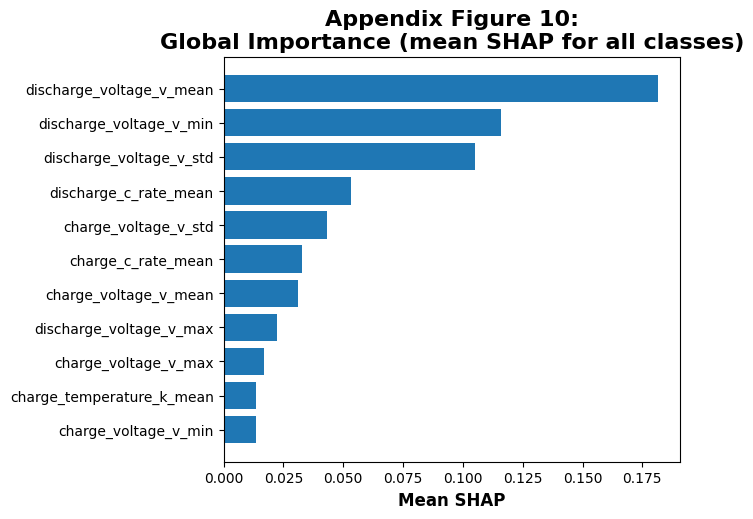


Top Features:


,feature,mean_abs_shap
0,discharge_voltage_v_mean,0.181641
1,discharge_voltage_v_min,0.116112
2,discharge_voltage_v_std,0.104928
3,discharge_c_rate_mean,0.053223
4,charge_voltage_v_std,0.043182
5,charge_c_rate_mean,0.032728
6,charge_voltage_v_mean,0.031143
7,discharge_voltage_v_max,0.022257
8,charge_voltage_v_max,0.016693
9,charge_temperature_k_mean,0.013524


In [4]:
feature_names = X.columns.tolist()
class_labels = encoder.classes_.tolist()
n_classes = len(class_labels)
n_features = len(feature_names)
assert len(feature_names) == n_features, \
    f"feature_names length {len(feature_names)} != n_features {n_features}"

# 1. SHAP Explainer on predict_proba
explainer = shap.Explainer(best_model.predict_proba, X_scaled, feature_names=feature_names)
shap_exp = explainer(X_scaled)

vals = shap_exp.values  # raw SHAP values (unknown axis order)
print("Raw SHAP shape:", vals.shape)



# Get real counts
real_samples = X_scaled.shape[0]

# helper mapping
axes = vals.shape

axis_candidates = {
    "features": [i for i, s in enumerate(axes) if s == n_features],
    "samples":  [i for i, s in enumerate(axes) if s == real_samples],
    "classes":  [i for i, s in enumerate(axes) if s == n_classes]
}

if not (axis_candidates["features"] 
        and axis_candidates["samples"] 
        and axis_candidates["classes"]):
    raise ValueError(f"Cannot match axes {axes} to (features={n_features}, samples={real_samples}, classes={n_classes})")

f_axis = axis_candidates["features"][0]
s_axis = axis_candidates["samples"][0]
c_axis = axis_candidates["classes"][0]

# Reorder to (classes, samples, features)
vals = np.moveaxis(vals, [c_axis, s_axis, f_axis], [0, 1, 2])

print("Normalized SHAP shape (classes, samples, features):", vals.shape)

# ------------------------------------
# 2. Global Feature Importance
# ------------------------------------
mean_abs_by_feature = np.mean(np.abs(vals), axis=(0,1))

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_by_feature
}).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

plt.figure(figsize=(7, 0.3 * n_features + 2))
plt.barh(feat_imp["feature"], feat_imp["mean_abs_shap"])
plt.gca().invert_yaxis()
plt.title("Appendix Figure 10:\nGlobal Importance (mean SHAP for all classes)", fontsize=16, fontweight='bold')
plt.xlabel("Mean SHAP", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop Features:")
display(feat_imp)

### Now See the Summary Plots Per Class

C:\Users\MJone\AppData\Local\Temp\ipykernel_3256\2853690890.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


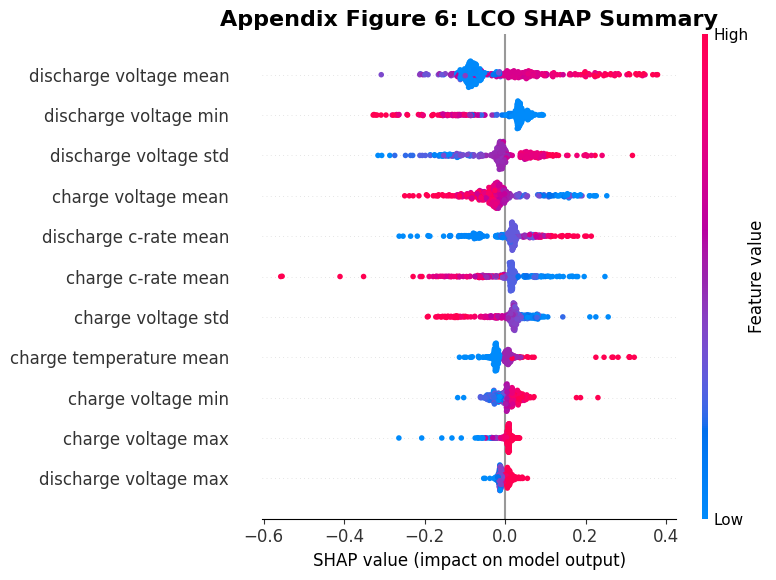

C:\Users\MJone\AppData\Local\Temp\ipykernel_3256\2853690890.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


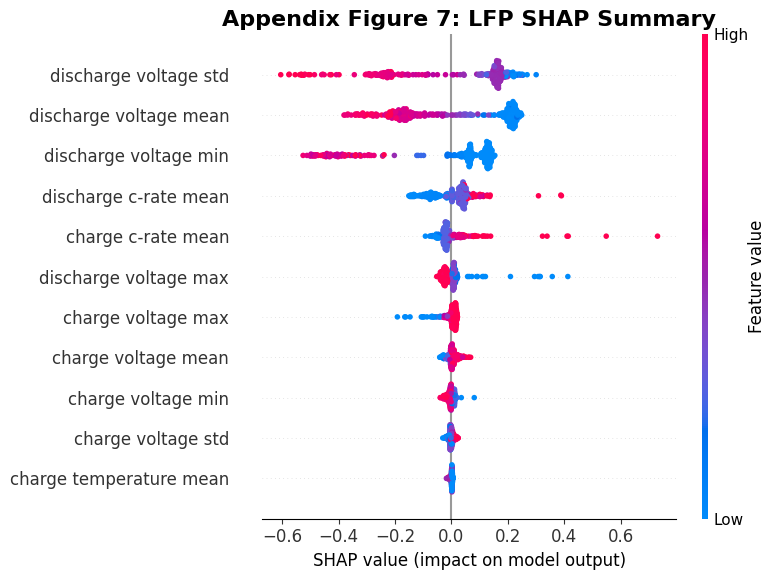

C:\Users\MJone\AppData\Local\Temp\ipykernel_3256\2853690890.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


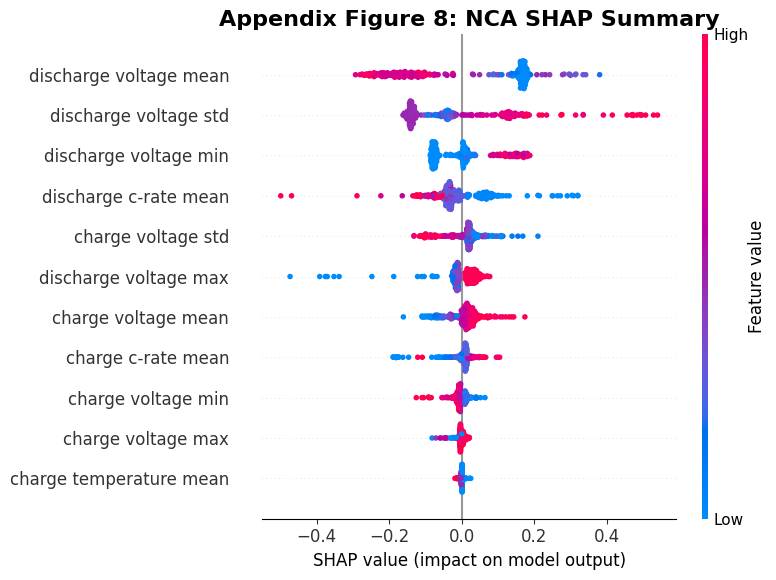

C:\Users\MJone\AppData\Local\Temp\ipykernel_3256\2853690890.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


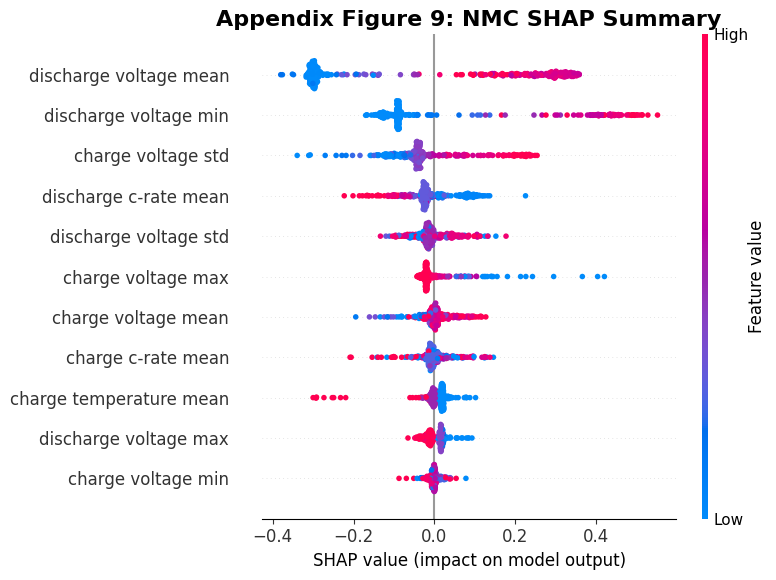

In [5]:
#Quick set of code to clean up the feature names
plot_features = [feature.replace('c_rate', 'c-rate') for feature in feature_names]
plot_features = [feature.replace('_', ' ') for feature in plot_features]
plot_features = [feature.replace(' v ', ' ') for feature in plot_features]
plot_features = [feature.replace(' k ', ' ') for feature in plot_features]

i = 5
# Now View the per Chemistry Summary Plots: 
for class_idx, chemistry in enumerate(encoder.classes_):
    i += 1
    #Create Plot
    plt.figure(figsize=(7,4))
    shap.summary_plot(
        vals[class_idx],
        X_scaled,
        feature_names=plot_features,
        show=False
    )

    ax = plt.gca()
    plt.title(f"Appendix Figure {i}: {chemistry} SHAP Summary", fontsize=16, fontweight='bold')
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)

    # Tick label sizes
    ax.tick_params(axis='both', labelsize=12)

    plt.tight_layout()
    plt.show()

C:\Users\MJone\AppData\Local\Temp\ipykernel_3256\1026855951.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


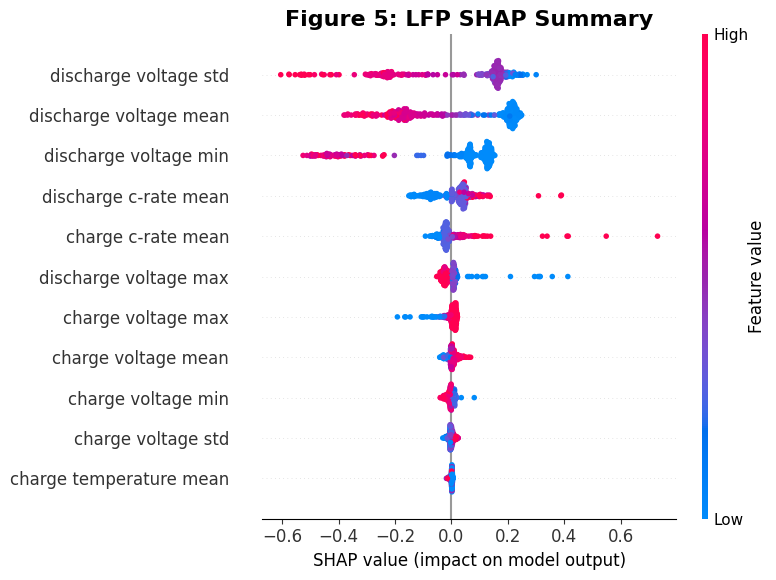

In [6]:
#Quick replot and re-label for the report: 
#Quick set of code to clean up the feature names
plot_features = [feature.replace('c_rate', 'c-rate') for feature in feature_names]
plot_features = [feature.replace('_', ' ') for feature in plot_features]
plot_features = [feature.replace(' v ', ' ') for feature in plot_features]
plot_features = [feature.replace(' k ', ' ') for feature in plot_features]

i = 3
# Now View the per Chemistry Summary Plots: 
for class_idx, chemistry in enumerate(encoder.classes_):
    i += 1
    if i == 5: 
        #Create Plot
        plt.figure(figsize=(7,4))
        shap.summary_plot(
            vals[class_idx],
            X_scaled,
            feature_names=plot_features,
            show=False
        )

        ax = plt.gca()
        plt.title(f"Figure {i}: {chemistry} SHAP Summary", fontsize=16, fontweight='bold')
        ax.xaxis.label.set_size(12)
        ax.yaxis.label.set_size(12)

        # Tick label sizes
        ax.tick_params(axis='both', labelsize=12)

        plt.tight_layout()
        plt.show()

### Examine Prediction Probabilities by Mean Voltages

Finally, since our selected model is a multinomial logistic regression classifier, we can examine how prediction probability is affected by specific features. We'll demonstrate how the mean voltage provided by a test dataset influences the predicted chemistry class. If you're interested, feel free to explore the other features and their impacts as well. 

Let's get started.... 

C:\Users\MJone\AppData\Local\Temp\ipykernel_3256\1872772321.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = plot_df.groupby('mv_bin').mean(numeric_only=True).reset_index()


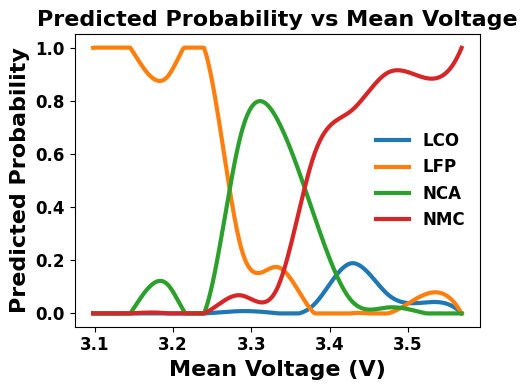

In [11]:
# Add interpolation imports
from scipy.interpolate import make_interp_spline

# Ensure required columns exist
mean_volt_cols = [c for c in X.columns if c.endswith('voltage_v_mean')]
if len(mean_volt_cols) == 0:
    raise ValueError("No '*voltage_v_mean' columns found in X. Expected e.g. 'discharge_voltage_v_mean'.")

# Prefer discharge mean voltage if present, else use the first available
mv_col = next((c for c in mean_volt_cols if 'discharge_' in c), mean_volt_cols[0])

# Predicted probabilities for test set
y_proba = best_model.predict_proba(X_scaled)

# Build plotting DataFrame
plot_df = pd.DataFrame({'mean_voltage': X[mv_col].values})
for i, cls in enumerate(class_labels):
    plot_df[f'proba_{cls}'] = y_proba[:, i]

# Bin mean voltage for smoother base points
bins = np.linspace(plot_df['mean_voltage'].min(), plot_df['mean_voltage'].max(), 12)
plot_df['mv_bin'] = pd.cut(plot_df['mean_voltage'], bins=bins, include_lowest=True)
agg = plot_df.groupby('mv_bin').mean(numeric_only=True).reset_index()
agg['mv_mid'] = agg['mv_bin'].apply(lambda x: (x.left + x.right) / 2 if pd.notna(x) else np.nan)

# Plot with transparent background
fig, ax = plt.subplots(figsize=(5, 4))
fig.patch.set_alpha(0)
ax.set_facecolor('none')
plt.rcParams['savefig.facecolor'] = 'none'


# Smooth and plot each class
for cls in class_labels:
    x = agg['mv_mid'].to_numpy()
    y = agg[f'proba_{cls}'].to_numpy()

    # clean/sort/unique for spline
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    order = np.argsort(x)
    x, y = x[order], y[order]
    x_u, idx = np.unique(x, return_index=True)
    y_u = y[idx]

    # build spline if enough points, else fall back to raw
    if len(x_u) >= 4:
        xnew = np.linspace(x_u.min(), x_u.max(), 300)
        spl = make_interp_spline(x_u, y_u, k=3)  # cubic spline
        power_smooth = np.clip(spl(xnew), 0, 1)  # keep within [0,1]
        ax.plot(xnew, power_smooth, linewidth=3, label=cls)
    else:
        ax.plot(x_u, y_u, linewidth=3, label=cls)

ax.set_xlabel('Mean Voltage (V)', fontsize=16, fontweight='bold')
ax.set_ylabel('Predicted Probability', fontsize=16, fontweight='bold')
ax.set_title('Predicted Probability vs Mean Voltage', fontsize=16, fontweight='bold')



leg = ax.legend(fontsize=12, loc='best', framealpha=0)
if leg:
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_edgecolor('none')
    #set bold for legend text
    for text in leg.get_texts():
        text.set_fontweight('bold')

ax.tick_params(axis='both', labelsize=12)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
plt.show()

That's the end of this notebook! 